In [1]:
import os
import ast
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import seaborn as sns

In [2]:
final_set = []
for f in os.listdir('sep_articles_lemmatized/'):
    with open('sep_articles_lemmatized/' + f) as text:
        final_set.append(ast.literal_eval(text.read()))

In [3]:
body = [' '.join(text) for text in final_set]

# Using a simple count vectorizer

In [ ]:
vectorizer = CountVectorizer()

In [ ]:
bag_of_words = vectorizer.fit_transform(body)

In [ ]:
bag_of_words.todense()

In [ ]:
from sklearn.decomposition import TruncatedSVD

In [ ]:
svd = TruncatedSVD(n_components=20)
lsa = svd.fit_transform(bag_of_words)

In [ ]:
import pandas as pd

In [ ]:
topic_encoded_df = pd.DataFrame(lsa, columns = ["topic_" + str(x) for x in xrange(1,21)])
topic_encoded_df['body'] = body
topic_encoded_df

In [ ]:
dictionary = vectorizer.get_feature_names()
encoding_matrix = pd.DataFrame(svd.components_, index=["topic_" + str(x) for x in xrange(1,21)], columns = dictionary).T

In [ ]:
import numpy as np

In [ ]:
for x in xrange(1,21):
    string = 'topic_%s' % x
    encoding_matrix['abs_' + string] = np.abs(encoding_matrix[string])
    
encoding_matrix.sort_values('abs_topic_2', ascending=False)

# Using K Nearest Neighbors Clustering

In [3]:
from sklearn.cluster import KMeans

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

### Feature extraction

In [5]:
tfidf_vectorizer = TfidfVectorizer()

In [6]:
body = [' '.join(text) for text in final_set[:100]]
tf_idf = tfidf_vectorizer.fit_transform(body)

### Finding the number of topics
Here we loop over a range of models varying in the number of clusters we expect the K Means model to cluster the texts into.

In [40]:
num_clusters = xrange(10,50)
models = [KMeans(n_clusters=x, init='k-means++', max_iter=200, n_init=100).fit(tf_idf) for x in num_clusters]
centroids = [k.cluster_centers_ for k in models]  #get all centroids

We then plot these results and find the elbow point to find the best number of topics for our sample. Citing from https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a:

> Elbow method gives us an idea on what a good k number of clusters would be based on the sum of squared distance (SSE) between data points and their assigned clusters’ centroids. We pick k at the spot where SSE starts to flatten out and forming an elbow.

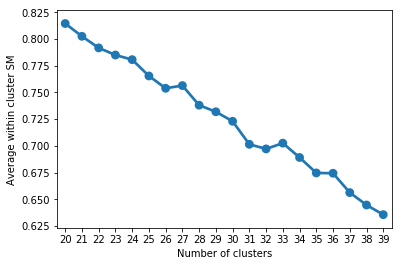

In [42]:
import numpy as np
from scipy.spatial.distance import cdist

# Find the distance between each point and its assigned centroid
D_k = [cdist(tf_idf.toarray(), cent,'euclidean') for cent in centroids]  #euclidean as a distance measure
eucldist = [np.min(D,axis=1) for D in D_k]  #find minimum distance

# Average within cluster sum of squares
avgWithinSM = [sum(d)/tf_idf.shape[0] for d in eucldist]

# Make a dataframe for plotting
sum_of_squares_df = pd.DataFrame()
sum_of_squares_df['Number of clusters'] = num_clusters
sum_of_squares_df['Average within cluster SM'] = avgWithinSM

# plot elbow
sns.pointplot(x = 'Number of clusters', y = 'Average within cluster SM', data = sum_of_squares_df)

### Writing a single model

Here we build a single model with a fixed number of clusters (ideally the number we found above). 

In [11]:
num_clusters = 27
modelkmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=200, n_init=100).fit(tf_idf)

In [43]:
modelkmeans = models[-1]

In [44]:
clusters = modelkmeans.labels_

We build a DataFrame with each document and then we add the vector containing info on which cluster does each document belong to.

In [45]:
doc_df = pd.DataFrame()
doc_df['Document'] = body
doc_df['Clusters'] = clusters

We can now count how many documents are in each cluster. Let's get some descriptives.

In [46]:
from collections import Counter
clusters_df = pd.DataFrame(Counter(clusters).items(), columns = ['Cluster', 'Num. of Docs'])
clusters_df['Num. of Docs'].describe()

count    39.000000
mean      2.564103
std       1.788779
min       1.000000
25%       1.000000
50%       2.000000
75%       3.500000
max       7.000000
Name: Num. of Docs, dtype: float64

Now let's see the number of documents per topic in a bar plot.

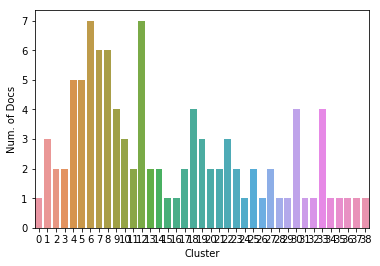

In [47]:
sns.barplot(x = 'Cluster', y = 'Num. of Docs', data = clusters_df)

Are the documents normally distributed?

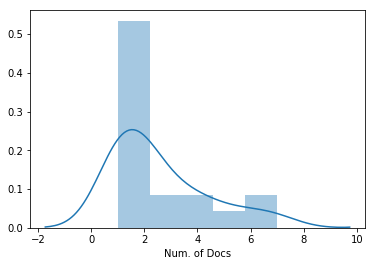

In [48]:
sns.distplot(clusters_df['Num. of Docs'])

### Getting the key words for each topic

To get words for each topic, we first organize each of the features in descending order relative to how close they are to its cluster's centroid. In other words, words that are closer to the centroid go first.

In [49]:
# Get cluster centroids and order the words in terms of how close
# they are to the centroid. These words right now are just numbers (features).
# We will later use the dictionary in the vectorizer to get the actual word.
ordered_centroids = modelkmeans.cluster_centers_.argsort()[:, ::-1]

Once we do that, we can use the vectorizer we used to get these features to bring them back into words. For each cluster, we can then have a list of words. Let's take out the 10 words that are closest to the cluster's centroid.

In [52]:
# For each cluster, we save details on the cluster.
# These details will include the list of key features, that is, the words
# that contribute most significantly to that cluster. 
key_features = []
for cluster_num in xrange(0, clusters_df.shape[0]):
    key_features.append([tfidf_vectorizer.get_feature_names()[index] for index in ordered_centroids[cluster_num, :10]])
clusters_df['Key Features'] = key_features

In [53]:
for cluster in clusters_df['Key Features']:
    print ' '.join(cluster)
    print "---"

democritus atom atomists report void atomist furley leucippus motion indivisible
---
macaulay hume law natural good moral aquinas human idea philo
---
woman feminist feminism liberal gender okin equity hermeneutical nussbaum continental
---
leibniz exoteric world substance esoteric possible adam god individual text
---
liberal government political montesquieu liberalism burke conservatism conservative global state
---
justification epistemology constructionist epistemic simplicity kornblith social parsimony goldman theory
---
consciousness dream conscious ryle theory state order mental content evidence
---
tarski logic mathematical niewski theory theorem quantifier system logical order
---
substance elisabeth descartes generic neutral monism property entity object thing
---
wolff enlightenment dilthey novalis human science fichte philosophy kant aesthetic
---
socrates plato dialogue name poetry cratylus rhetoric hermogenes poet homer
---
fictional object holmes possible actual vulcan p